# Export a dynamical decoupling sequence to Qiskit

Q-CTRL Open Controls provides easy-to-use methods to construct Dynamical Decoupling Sequences (DDS) according to well-known dynamical decoupling schemes. Here we show how a DDS from Q-CTRL Open Controls can be exported to a Qiskit circuit to run on an IBM Q device using Q-CTRL Qiskit Adapter. We also show how a DDS can decrease the number of errors, when executing a quantum circuit on a real quantum computer, by extending the coherence time.

Note:
* You need [Qiskit](https://qiskit.org/documentation/install.html) to create a quantum circuit. 
* You can use the [IBM Q Experience](https://quantum-computing.ibm.com) to run a quantum circuit.

## Imports

In [1]:
# General

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Q-CTRL Open Controls
from qctrlopencontrols import new_quadratic_sequence, new_ramsey_sequence

# Q-CTRL Qiskit Adapter
from qctrlqiskit import convert_dds_to_qiskit_quantum_circuit

# Q-CTRL Visualizer
from qctrlvisualizer import plot_sequences

# Qiskit
##To define a backend (simulated or real), transpile and assemble a circuit
from qiskit import BasicAer
from qiskit.compiler import transpile, assemble

##To plot the outcome
from qiskit.tools.visualization import plot_histogram

## To handle account information,find a suitable device and monitor a job
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

## Running a DDS on a Qiskit simulator

This section demonstrates how a DDS can be prepared and a corresponding Qiskit circuit made and executed on a Qiskit simulator.

Q-CTRL Open Controls defines a DDS as a set of instantaneous unitary operations performed at specific offset times, see the [technical documentation](https://docs.q-ctrl.com/open-controls/references/qctrl-open-controls/qctrlopencontrols/DynamicDecouplingSequence.html) for mathematical details.

Qiskit implements quantum computation through a series of [gates in a quantum circuit](https://qiskit.org/documentation/getting_started.html#circuit-basics). How these gates are physically implemented will depend on the device that it is run on.

On IBM Q devices, individual qubit rotations are completed using two basis elements. $Z$ rotations are performed with (almost) instantaneous clock shifts and $Y$ rotations are performed with microwave pulses over a fixed time. All single qubit gates are a combination of these two.

If a user wants to add pauses (in time) during a computation they can use identity gates and barriers. The barriers ensure that the circuit is not simplified before execution on the machine. Both identity gates and $X$ or $Y$ rotation gates take a fixed time (`gate_time`).

Converting a DDS into a Qiskit circuit is an approximate process where the instantaneous unitaries are replaced with finite duration gates and the pauses in-between unitaries are replaced with the closest integer number of identity gates. The exact algorithm used to make this approximation is documented in the [source code](https://github.com/qctrl/python-qiskit).

In this example we will define a Quadratic DDS and convert it into a circuit that we can later run on a simulator and on a real device. We also create a Ramsey DDS of the same duration to compare as a benchmark. For both the sequences, we add a $X_{\pi/2}$ rotation on either end of the sequence.

### Preparing the sequences

In [2]:
## Quadratic sequence, total duration: 20us
quadratic_sequence = new_quadratic_sequence(
    duration=20e-6,
    inner_offset_count=2,
    outer_offset_count=2,
    pre_post_rotation=True,
    name="Quadratic sequence",
)

# Ramsey sequence, total duration: 20us
ramsey_sequence = new_ramsey_sequence(
    duration=20e-6, pre_post_rotation=True, name="Ramsey sequence"
)

print(quadratic_sequence)
print(ramsey_sequence)

Quadratic sequence:
Duration = 2e-05
Offsets = [0.0, 0.06249999999999998, 0.18749999999999994, 0.24999999999999994, 0.37499999999999994, 0.6249999999999999, 0.7499999999999999, 0.8124999999999999, 0.9375, 1.0] x 2e-05
Rabi Rotations = [0.5, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.5] x pi
Azimuthal Angles = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] x pi
Detuning Rotations = [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0] x pi
Ramsey sequence:
Duration = 2e-05
Offsets = [0.0, 1.0] x 2e-05
Rabi Rotations = [0.5, 0.5] x pi
Azimuthal Angles = [0.0, 1.0] x pi
Detuning Rotations = [0.0, 0.0] x pi


### Constructing the QuantumCircuit using Q-CTRL Open Controls

To construct a `QuantumCircuit` from a DDS we need:
* `dynamic_decoupling_sequence` - a DDS. 
* `target_qubits` - a list of od qubit indices on which the DDS will be applied. 
* `gate_time` is the delay (in seconds) introduced by each of the `identity` gates. 
* (optional) `add_measurement` - if a measurement is required.

In this example, we will use $0$th qubit and specify the `gate_time` to be $0.4$ $\mu$s. Both the DDS will require a measurement operation.

In [3]:
## Prepare the Qiskit related parameters
"""
target_qubits : list
    A list of integers specifying the target qubits within the set of qubit registers
"""
target_qubits = [0]

"""
gate_time : float
    Time delay (in seconds) introduced by identity gate
"""
gate_time = 0.4e-6

"""
add_measurement : bool
    Indicates if the circuit requires a measurement step.
    Required for 'qasm_simulator' and real device backends
"""
add_measurement = True

"""
circuit_name : str
    An optional string as a name to the circuit
"""
circuit_name = "quadratic-sequence-circuit"

## convert the quadratic sequence to QuantumCircuit

quadratic_quantum_circuit = convert_dds_to_qiskit_quantum_circuit(
    dynamic_decoupling_sequence=quadratic_sequence,
    target_qubits=target_qubits,
    gate_time=gate_time,
    add_measurement=add_measurement,
    circuit_name=circuit_name,
)

## convert the ramsey sequence to QuantumCircuit
circuit_name = "ramsey-sequence-circuit"
ramsey_quantum_circuit = convert_dds_to_qiskit_quantum_circuit(
    dynamic_decoupling_sequence=ramsey_sequence,
    target_qubits=target_qubits,
    gate_time=gate_time,
    add_measurement=add_measurement,
    circuit_name=circuit_name,
)

### Plotting the DDS

We can use the Q-CTRL Python Visualizer package to plot the DDS for comparison against their Qiskit circuit approximations.

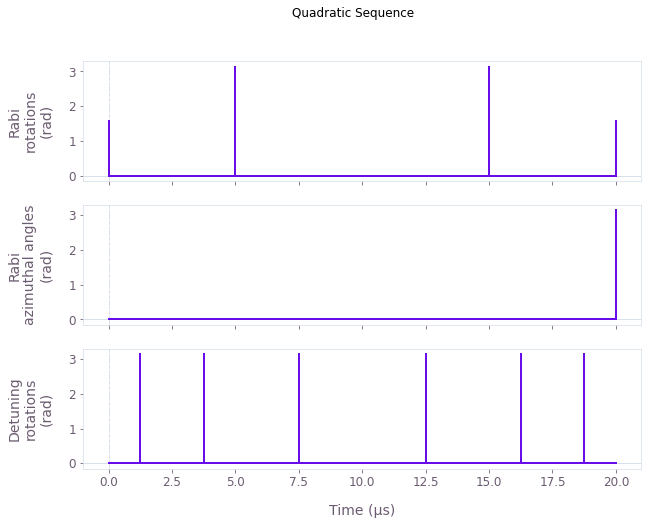

In [4]:
formatted_plot_data = quadratic_sequence.export()
figure = plt.figure()
plt.suptitle("Quadratic Sequence")
plot_sequences(figure, formatted_plot_data)

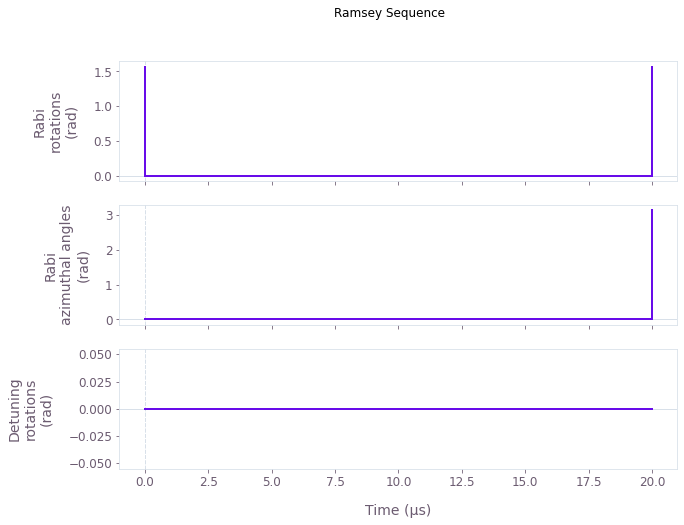

In [5]:
formatted_plot_data = ramsey_sequence.export()
figure = plt.figure()
plt.suptitle("Ramsey Sequence")
plot_sequences(figure, formatted_plot_data)

### Drawing the circuits

We can use Qiskit to draw the circuits generated by Q-CTRL Open Controls.

#### Drawing the Quadratic DDS Circuit

Note that both DDS will be applied with $X_{\pi/2}$ rotations at beginning and end, that is, at offsets of $[0, 20]$ $\mu$s, to create the desired superposition state. The $X_{\pi/2}$ rotations are added to the circuits in the form of pre-post-gates that are implemented via Qiskit's $U3(\pi/2, -\pi/2, \pi/2)$ gate.

The $U1(\pi)$ gates are $Z_\pi$ pulses (a $\pi$ rotation around $Z$-axis) and $U3(\pi, -\pi/2, \pi/2)$ gates correspond to $X_{\pi}$ pulses (a $\pi$ rotation around $X$-axis). The gates match the pulses in the DDS.

The `Id` in the drawing corresponds to the `identity` gate. In the DDS, the first $Z_{\pi}$-pulse is applied at a delay of $1.25$ $\mu$s. This is approximated by introducing 3-`Id` gates with a delay of $0.4\times 3=1.2$ $\mu s$. Similarly, the second set of 6 `Id` gates introduces a delay of $2.4$ $\mu s$ close to the actual delay of $3.75-1.25=2.50\mu s$.

The `barrier` gates are special gates that tell the Qiskit compilers not to simplify a circuit at the specified positions.

At the end of each circuit, we place a `measurement` operator to read out the result.

In [6]:
##Drawing the Quadratic Circuit
quadratic_quantum_circuit.draw()

┌──────────────────┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───────┐ ░ ┌───┐ ░ ┌───┐»
q0_0: ┤ U3(π/2,-π/2,π/2) ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ U1(π) ├─░─┤ I ├─░─┤ I ├»
      └──────────────────┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───────┘ ░ └───┘ ░ └───┘»
c0: 1/════════════════════════════════════════════════════════════════════════»
                                                                              »
«       ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───────┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q0_0: ─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ U1(π) ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
«       ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───────┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
«c0: 1/═══════════════════════════════════════════════════════════════════════»
«                                                                             »
«      ┌────────────────┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q0_0: ┤ U3(π,-π/2,π/2) ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
«      └────────────────┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
«c0: 1/═════════════════════════════════════════════════════════════════════»
«                                                                           »
«      ┌───────┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q0_0: ┤ U1(π) ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
«      └───────┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
«c0: 1/════════════════════════════════════════════════════════════════════»
«                                                                          »
«      ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───────┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q0_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ U1(π) ├─░─┤ I ├─░─┤ I ├─░─»
«      └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───────┘ ░ └───┘ ░ └───┘ ░ »
«c0: 1/════════════════════════════════════════════════════════════════════»
«                                                                          »
«      ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌────────────────┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q0_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ U3(π,-π/2,π/2) ├─░─┤ I ├─░─┤ I ├─░─»
«      └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └────────────────┘ ░ └───┘ ░ └───┘ ░ »
«c0: 1/═════════════════════════════════════════════════════════════════════»
«                                                                           »
«      ┌───┐ ░ ┌───────┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q0_0: ┤ I ├─░─┤ U1(π) ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
«      └───┘ ░ └───────┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
«c0: 1/════════════════════════════════════════════════════════════════════»
«                                                                          »
«      ┌───────┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───────────────────┐ ░ ┌─┐
«q0_0: ┤ U1(π) ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ U3(-π/2,-π/2,π/2) ├─░─┤M├
«      └───────┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───────────────────┘ ░ └╥┘
«c0: 1/═════════════════════════════════════════════════════════════╩═
«                                                                   0

#### Drawing the Ramsey DDS Circuit

The drawing below shows the Ramsey DDS circuit consists of `Id` or `identity` gates surrounded by $X_{\pi/2}$-pulses on both ends. The `measurement` operator appears at the end as in the original definition of the circuit. This will help us run the circuit in one of the simulators.

In [7]:
ramsey_quantum_circuit.draw()

┌──────────────────┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
q1_0: ┤ U3(π/2,-π/2,π/2) ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
      └──────────────────┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
c1: 1/═══════════════════════════════════════════════════════════════════════»
                                                                             »
«      ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q1_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
«      └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
«c1: 1/════════════════════════════════════════════════════════════════════════»
«                                                                              »
«      ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q1_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
«      └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
«c1: 1/════════════════════════════════════════════════════════════════════════»
«                                                                              »
«      ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q1_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
«      └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
«c1: 1/════════════════════════════════════════════════════════════════════════»
«                                                                              »
«      ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q1_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
«      └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
«c1: 1/════════════════════════════════════════════════════════════════════════»
«                                                                              »
«      ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q1_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
«      └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
«c1: 1/════════════════════════════════════════════════════════════════»
«                                                                      »
«      ┌───────────────────┐ ░ ┌─┐
«q1_0: ┤ U3(-π/2,-π/2,π/2) ├─░─┤M├
«      └───────────────────┘ ░ └╥┘
«c1: 1/═════════════════════════╩═
«                               0

And here we count 50 `Id` operations, implementing a total delay of $50 \times 0.4 = 20 \mu s$

In [8]:
print(ramsey_quantum_circuit.count_ops()["id"])

50


### Run the circuit on Qiskit Simulator using Qiskit API

Before running our circuits on the real IBM Q hardware, let's run them through a simulator first.

Consult [Simulating Circuits using Qiskit Aer](https://qiskit.org/documentation/getting_started.html#simulating-circuits-using-qiskit-aer) for a description of available simulators and their respective properties.

Here, we will use the `qasm-simulator` to run the circuit. The experiment consists of `number_of_shots` repeats of the circuit operations on a qubit. Each run collects the state of the qubit as measurement. The result is displayed as a histogram.

In [9]:
## Prepares the simulator backend
"""
backend : str
    One of 'unitary_simulator', 'statevector_simulator' or 'qasm_simulator';
    defaults to 'qasm_simulator'
"""
backend = "qasm_simulator"
backend_simulator = BasicAer.get_backend(backend)

"""
number_of_shots : int
    Number of repeats the experiment has to be carried out;
    defaults to 1
"""
number_of_shots = 1024

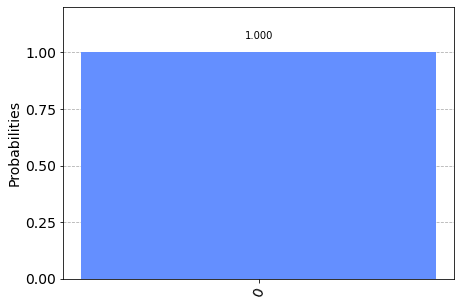

In [10]:
## Run the quadratic sequence circuit, Get the result (counts of state |1> and |0>), plot the histogram

# Transpile and assemble the circuits so that the identity gates are preserved
transpiled_quadratic_circuit = transpile(
    quadratic_quantum_circuit, backend=backend_simulator, optimization_level=0
)
assembled_quadratic_circuit = assemble(
    transpiled_quadratic_circuit, shots=number_of_shots
)

# run the circuit
job = backend_simulator.run(assembled_quadratic_circuit)
result = job.result()
counts = result.get_counts(quadratic_quantum_circuit)
plot_histogram(counts)

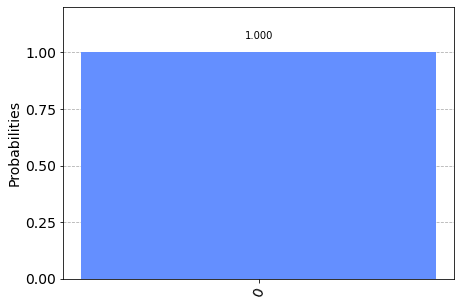

In [11]:
## Run the ramsey sequence circuit, Get the result (counts of state |1> and |0>), plot the histogram

# Transpile and assemble the circuits so that the identity gates are preserved
transpiled_ramsey_circuit = transpile(
    ramsey_quantum_circuit, backend=backend_simulator, optimization_level=0
)
assembled_ramsey_circuit = assemble(transpiled_ramsey_circuit, shots=number_of_shots)

job = backend_simulator.run(assembled_ramsey_circuit)
result = job.result()
counts = result.get_counts(ramsey_quantum_circuit)
plot_histogram(counts)

## Running a dynamical decoupling sequence on a real device

Now that we've verified that our circuits run on the simulators, let's take a look at what happens when we run them on the real IBM Q devices.

We use the same DDS and circuit defined above and use Qiskit's APIs to run the circuit. See [Running Circuits on IBM Q Devices](https://qiskit.org/documentation/getting_started.html#running-circuits-on-ibm-q-devices) for a more detailed explanation of the APIs used here.

### Select a suitable device based on account type and configuration using Qiskit API

We use a basic configuration and choose the least busy device.

In [13]:
# NBVAL_SKIP
"""
account_token : str
    Token to enable IBM Q device access
"""
account_token = "insert-your-ibmq-token-here"
IBMQ.enable_account(account_token)
provider = IBMQ.get_provider(hub="ibm-q", group="open")
backends = provider.backends()
backends = [backend for backend in backends if backend.name() != "ibmq_qasm_simulator"]

backend = least_busy(backends)
print("Least busy device is {}".format(backend.name()))

Least busy device is ibmq_ourense


### Run the circuits on a real device using Qiskit API

#### Run the assembled Quadratic sequence

Job Status: job has successfully run


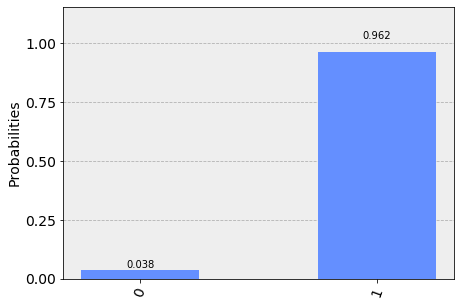

In [14]:
# NBVAL_SKIP

job = backend.run(assembled_quadratic_circuit)
job_monitor(job)
result = job.result()
counts = result.get_counts(quadratic_quantum_circuit)
plot_histogram(counts)

#### Run the assembled Ramsey sequence

Job Status: job has successfully run


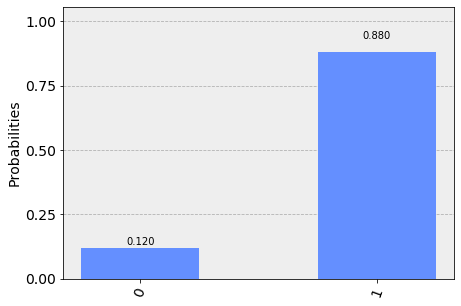

In [15]:
# NBVAL_SKIP

job = backend.run(assembled_ramsey_circuit)
job_monitor(job)
result = job.result()
counts = result.get_counts(ramsey_quantum_circuit)
plot_histogram(counts)

### Close the account

Just to make sure, close the account after the task is over.

In [16]:
# NBVAL_SKIP
IBMQ.disable_account()

## Reducing errors by increasing the coherence time

In the ideal noiseless simulator, both the Ramsey DDS and Quadratic DDS produced exactly the same outcome, the $|1 \rangle$ state with probability 1. However, in a real device, we can see a marked difference. The Quadratic DDS produced a probability distribution closer to the expected outcome. This is because the Quadratic DDS is able to cancel the effects of magnetic noise in the environment - extending the [T2 time](https://en.wikipedia.org/wiki/Spin–spin_relaxation), and effectively increasing the coherence of the qubit.